# COMP90051 Project 2

In [1]:
# Do not edit. These are the only imports permitted.
%matplotlib inline
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod

## 1. Implement ε-Greedy and UCB

In [2]:
class MAB(ABC):
    """
    Abstract class that represents a multi-armed bandit (MAB)
    """
    
    @abstractmethod
    def play(self, tround, context):
        """
        Play a round
        
        Arguments
        =========
        tround : int
            positive integer identifying the round
        
        context : 1D float array, shape (self.ndims * self.narms), optional
            context given to the arms
        
        Returns
        =======
        arm : int
            the positive integer arm id for this round
        """
    
    @abstractmethod
    def update(self, arm, reward, context):
        """
        Updates the internal state of the MAB after a play
        
        Arguments
        =========
        arm : int
            a positive integer arm id in {1, ..., self.narms}
        
        reward : float
            reward received from arm
        
        context : 1D float array, shape (self.ndims * self.narms), optional
            context given to arms
        """

In [3]:
class EpsGreedy(MAB):
    """
    Epsilon-Greedy multi-armed bandit

    Arguments
    =========
    narms : int
        number of arms

    epsilon : float
        explore probability

    Q0 : float, optional
        initial value for the arms
    """
    
    def __init__(self, narms, epsilon, Q0=np.inf):
        self.narms = narms
        self.epsilon = epsilon
        self.count = np.zeros(narms,np.int)  # the number of pulling for each arm
        self.Q_values = np.array([Q0] * narms)    # init Q_values set to infinity
        

    def play(self, tround, context=None):
        if np.random.random() > self.epsilon:        # a random float number in interval[0.0, 1.0), if random number > epsilon -> exploit
            max_Q = max(self.Q_values)
            return np.random.choice([i for i,v in enumerate(self.Q_values) if v == max_Q])  # Tie-breaking: randomly choose the largest value
        else:                                                
            return np.random.randint(self.narms)     # if random number < epsilon -> explore
        
    def update(self, arm, reward, context=None):
        self.count[arm] += 1
        step_size = self.count[arm]
        if self.Q_values[arm] == np.inf:  # if pre_Qvalue is infinity -> change to 0
            self.Q_values[arm] = 0
        old_estimate = self.Q_values[arm]
        self.Q_values[arm] = ((step_size - 1) / float(step_size)) * old_estimate + (1 / float(step_size)) * reward

    

In [4]:
class UCB(MAB):
    """
    Upper Confidence Bound (UCB) multi-armed bandit

    Arguments
    =========
    narms : int
        number of arms

    rho : float
        positive real explore-exploit parameter

    Q0 : float, optional
        initial value for the arms
    """
    
    def __init__(self, narms, rho, Q0=np.inf):
        self.narms = narms
        self.rho = rho
        self.count = np.zeros(narms,np.int)       # the number of pulling for each arm
        self.Q_values = np.array([Q0] * narms)    # init Q_values set to infinity
        self.UCB_values = np.zeros(narms)         # init UCB_values set to 0
    
    def play(self, tround, context=None):
        for arm in range (self.narms):
            if self.count[arm] == 0:              # if this arm has not been pulled, its UCB_value will be set to infinity
                self.UCB_values[arm] = self.Q_values[arm]
            else:
                self.UCB_values[arm] = self.Q_values[arm] + np.sqrt((self.rho * np.log(sum(self.count))) / float(self.count[arm]))
        max_UCB = max(self.UCB_values)
        return np.random.choice([i for i,v in enumerate(self.UCB_values) if v == max_UCB])   # Tie-breaking: randomly choose the largest value
    
    def update(self, arm, reward, context=None):
        self.count[arm] += 1
        step_size = self.count[arm]
        if self.Q_values[arm] == np.inf:      # if pre_Qvalue is infinity -> change to 0
            self.Q_values[arm] = 0
        old_estimate = self.Q_values[arm]
        self.Q_values[arm] = ((step_size - 1) / float(step_size)) * old_estimate + (1 / float(step_size)) * reward
        
    

## 2. Off-Policy Evaluation

In [5]:
def offlineEvaluate(mab, arms, rewards, contexts, nrounds=None):
    """
    Offline evaluation of a multi-armed bandit
    
    Arguments
    =========
    mab : instance of MAB
    
    arms : 1D int array, shape (nevents,) 
        integer arm id for each event
    
    rewards : 1D float array, shape (nevents,)
        reward received for each event
    
    contexts : 2D float array, shape (nevents, mab.narms*nfeatures)
        contexts presented to the arms (stacked horizontally) 
        for each event.
        
    nrounds : int, optional
        number of matching events to evaluate `mab` on.
    
    Returns
    =======
    out : 1D float array
        rewards for the matching events
    """
    index = 0              #  index of each event
    matchNum = 0           #  if arm matched, this number will plus 1, until >= nrounds 
    rewardsRecord = []     #  record each matched event's record, its length will equal to 800 finally in this example
    for arm in arms:
        if matchNum >= nrounds:
            return rewardsRecord
        elif mab.play(len(rewardsRecord),contexts[index]) == arm - 1:   # arm here is from 1-10, will be changed to 0-9 to fit the method
            mab.update(arm - 1,rewards[index],contexts[index])   # arm here is from 1-10, will be changed to 0-9 to fit the method
            rewardsRecord.append(rewards[index])
            matchNum += 1
            index += 1
        else:
            index += 1     # not match, jump to next event
            continue
            
    

In [6]:
def getDataset():    # this method is used to return the first column (arms), second column(rewards), and rest matrix(contexts),given the dataset.txt
    dataset = np.loadtxt("C:\\Users\\vincent916735\\Desktop\\dataset.txt")
    arms = [int(x) for x in dataset[:,0]]
    rewards = dataset[:,1]
    contexts = dataset[:,2:]
    return arms,rewards,contexts

In [11]:

mab = EpsGreedy(10, 0.05)
arms,rewards,contexts = getDataset()
results_EpsGreedy = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('EpsGreedy average reward', np.mean(results_EpsGreedy))

EpsGreedy average reward 0.24125


In [13]:
mab = UCB(10, 1.0)
arms,rewards,contexts = getDataset()
results_UCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('UCB average reward', np.mean(results_UCB))

UCB average reward 0.15875


## 3. Contextual Bandits

In [14]:
class LinUCB(MAB):
    """
    Contextual multi-armed bandit (LinUCB)

    Arguments
    =========
    narms : int
        number of arms

    ndims : int
        number of dimensions for each arm's context

    alpha : float
        positive real explore-exploit parameter
    """
    
    def __init__(self, narms, ndims, alpha):
        self.narms=narms
        self.ndims=ndims
        self.alpha=alpha
        self.A = {}  # dictionary to store A matrix
        self.b = {}  # dictionary to store b matrix
        self.AI = {}   # dictionary to store A's inverse matrix
        self.p=[0 for i in range(self.narms)]  # initial value set to 0
        for arm in range(self.narms):
            self.A[arm] = np.identity(self.ndims)   # initial A matrix for 10 arms: 10-dimensional identity matrix
            self.b[arm] = np.zeros((self.ndims,1))  # initial b matrix for 10 arms: 10-dimensional zero vector

    def play(self, tround, context):
        for arm in range(self.narms):       
            xt = np.array([context[arm]]) # get this arm's feature, context[arm] looks like: [_,_,_,_,_,_,_,_,_,_]
            xtT = np.transpose(xt)   
            self.AI[arm] = np.linalg.inv(self.A[arm])
            theta = np.dot(self.AI[arm],self.b[arm])
            p = np.dot(np.transpose(theta),xtT) + self.alpha * np.sqrt(np.dot(np.dot(xt,self.AI[arm]),xtT))
            self.p[arm] = p
        maxP = max(self.p)
        return np.random.choice([i for i,v in enumerate(self.p) if v == maxP]) # Tie-breaking, randomly choose value in maxValue set
    
    def update(self, arm, reward, context):    
        xt=np.array([context[arm]])
        xtT = np.transpose(xt)
        self.A[arm] = self.A[arm] + np.dot(xtT,xt)
        self.b[arm] = self.b[arm] + reward * xtT

In [15]:
 """
 This method will return _contexts for LinUCB only, in order to simplfy the calculation. the only difference between
 contexts and _contexts is:
 for each rows in contexts: [_,_,_,...] ,100 elements in the list
 for each rows in _contexts: [[10 features for arm 1],[10 features for arm 2],[10 features for arm 3]...]
 In this case, in LinUCB's play(), arm's feature will be context[arm]
 """
def get_contexts(): 
    _contexts=[]
    dataset = open("C:\\Users\\vincent916735\\Desktop\\dataset.txt")
    contexts = dataset.readlines()   
    for row in contexts:
        preContext = row.split(' ')    
        adjustedContext=[]
        t=[]
        for num in range(2,102):
            if(num - 2 != 0 and (num - 2) % 10 == 0):
                adjustedContext.append(t)
                t=[]         
            t.append(int(preContext[num]))          
        adjustedContext.append(t)  
        _contexts.append(adjustedContext)
    return _contexts

In [16]:
_contexts = get_contexts()
mab = LinUCB(10, 10, 1.0)
results_LinUCB = offlineEvaluate(mab, arms, rewards,_contexts, 800)
print('LinUCB average reward', np.mean(results_LinUCB))

LinUCB average reward 0.53


## 4. Evaluation
### 4.A.

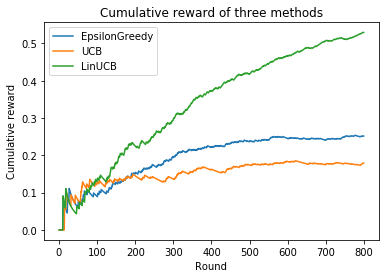

In [18]:
plt.figure()
plt.title('Cumulative reward of three methods')
plt.xlabel('Round')
plt.ylabel('Cumulative reward')
mab = EpsGreedy(10, 0.05)
arms,rewards,contexts = getDataset()
results_EpsGreedy = offlineEvaluate(mab, arms, rewards, contexts, 800)
mab = UCB(10, 1.0)
results_UCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
mab = LinUCB(10, 10, 1.0)
results_LinUCB = offlineEvaluate(mab, arms, rewards,_contexts, 800)
cul_EpsGreedy = []
cul_UCB = []
cul_LinUCB = []
index = []
for i in range(1,800):
    cul_EpsGreedy.append(np.mean(results_EpsGreedy[:i]))
    cul_UCB.append(np.mean(results_UCB[:i]))
    cul_LinUCB.append(np.mean(results_LinUCB[:i]))
    index.append(i)
plt.plot(index,cul_EpsGreedy,label="EpsilonGreedy")
plt.plot(index,cul_UCB,label="UCB")
plt.plot(index,cul_LinUCB,label="LinUCB")
plt.legend()
plt.show()

### 4.B.

The optimised alpha is  0.02
The largest average result is  0.73125


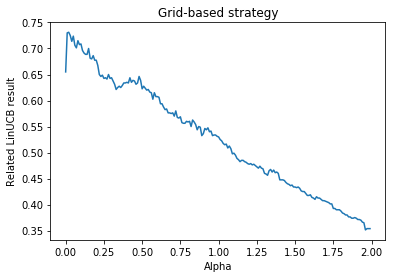

In [19]:
plt.figure()
plt.title('Grid-based strategy')
plt.xlabel('Alpha')
plt.ylabel('Related LinUCB result')
acc = 0     # acc is the accumulation of alpha, start from 0.1
addition = 0.01    # each time acc += addition
alpha = []     # alpha list to store different alpha value
results = []
bestAlpha = 0
result_Max = 0
for i in range(200):     # alpha try from 0.1, 0.2, 0.3... to 2.0
    alpha.append(acc)
    acc += addition
for a in alpha:
    mab = LinUCB(10, 10, a)
    arms,rewards,contexts = getDataset()
    results_LinUCB = offlineEvaluate(mab, arms, rewards, _contexts, 800)
    results.append(np.mean(results_LinUCB))
    if np.mean(results_LinUCB)> result_Max:
        result_Max = np.mean(results_LinUCB)
        bestAlpha = a
print('The optimised alpha is ',bestAlpha)
print('The largest average result is ',result_Max)
plt.plot(alpha,results) 